#                                                        **IA for HumanForYou** 
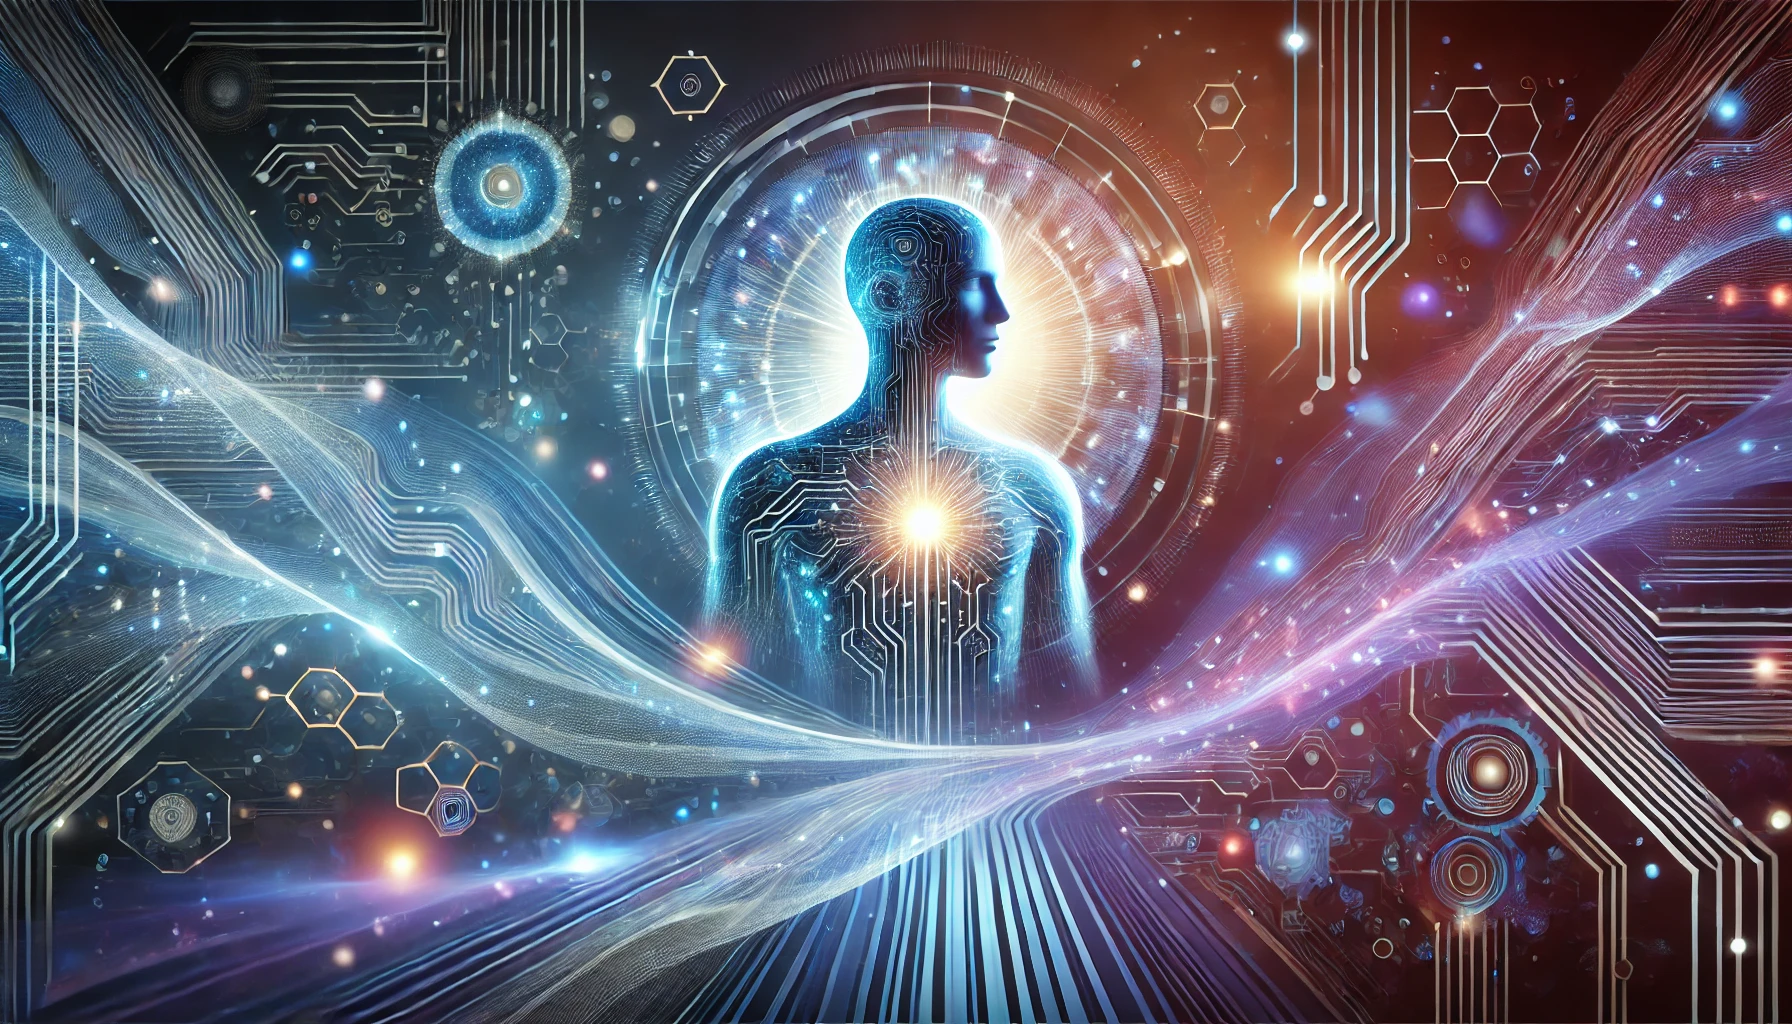

## Plan d'action

1. Importation des bibliothèques
2. Récupération des données
3. Vérification de la cohérence des données
4. Traitement des données manquantes
5. Analyse exploratoire des données
6. Analyse Univariée
7. Analyse Bivariée

## 1. Importation des bibliothèques


In [28]:
from DataExtractor.CSVExtractor import *
from Analysis.Structure import *
from Analysis.MissingData import *
from Analysis.Describe import *
from Normalization.Smithy import *
from Analysis.GraphicsDecriber import *
from Normalization.Imputation import *
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 2. Récupération des données

### **2.1 Liste des fichiers à fournir**

* **general_data.csv :** Informations démographiques et de base sur l’employé (âge, salaire, ancienneté, etc.), ainsi que l’indicateur d’attrition.
* **manager_survey_data.csv :** Évaluations du manager (JobInvolvement, PerformanceRating).
* **employee_survey_data.csv :** Notes de satisfaction des employés (EnvironmentSatisfaction, JobSatisfaction, WorkLifeBalance), avec potentiellement des valeurs manquantes (NA).
* **in_out_time.zip :** Données d’horaires d’entrée et de sortie par jour, permettant de calculer le temps de travail effectif, l’absentéisme, etc.
    * **in_time.csv :** Données d’horaires d’entrée par jour.
    * **out_time.csv :** Données d’horaires de sortie par jour.

### **2.2 Chargement des données**

In [29]:
try:
    general_df = create_dataframe("data/general_data.csv")
    manager_df = create_dataframe("data/manager_survey_data.csv")
    employee_df = create_dataframe("data/employee_survey_data.csv")
    in_time_df = create_dataframe("data/in_time.csv")
    out_time_df = create_dataframe("data/out_time.csv")
except Exception as e:
    print(e)
    exit()

## 3. Vérification de la cohérence des données

### **3.1 Échantillons de données**

In [30]:
display_df(general_df,"General Data")
display_df(manager_df,"Manager Data")
display_df(employee_df,"Employee Data")
display_df(in_time_df,"In time Data")
display_df(out_time_df,"Out time Data")

-------------------------------------------
 General Data 
-------------------------------------------
      Age Attrition  ... YearsSinceLastPromotion YearsWithCurrManager
0      51        No  ...                       0                    0
1      31       Yes  ...                       1                    4
...   ...       ...  ...                     ...                  ...
4408   42        No  ...                       7                    8
4409   40        No  ...                       3                    9

[4410 rows x 24 columns]
-------------------------------------------
 Manager Data 
-------------------------------------------
      EmployeeID  JobInvolvement  PerformanceRating
0              1               3                  3
1              2               2                  4
...          ...             ...                ...
4408        4409               2                  3
4409        4410               4                  3

[4410 rows x 3 columns]
-----------

### **3.2 Comprendre la structure et les variables**

In [31]:
visualize_structure(general_df, "General Data")
visualize_structure(manager_df, "Manager Data")
visualize_structure(employee_df, "Employee Data")
visualize_structure(in_time_df, "In time Data")
visualize_structure(out_time_df, "Out time Data")


-------------------------------------------
 General Data 
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410


***Identification des variables cibles et explicatives :***

* **Variable cible (dépendante)** : Attrition (Yes/No).
C’est sur cette variable que vous centrerez votre analyse et vos modèles prédictifs.

* **Variables explicatives (indépendantes) :**
Il s’agit de l’ensemble des autres variables susceptibles d’influencer l’attrition. Parmi les plus importantes, on peut citer :

* **Facteurs démographiques :** Age, Gender, MaritalStatus, Education, EducationField.
* **Facteurs professionnels :** JobRole, JobLevel, Department, TotalWorkingYears, YearsAtCompany, YearsSinceLastPromotion, YearsWithCurrManager, NumCompaniesWorked.
* **Facteurs financiers :** MonthlyIncome, PercentSalaryHike, StockOptionLevel.
* **Facteurs liés à la satisfaction et la performance :** JobInvolvement, PerformanceRating (manager_survey_data), EnvironmentSatisfaction, JobSatisfaction, WorkLifeBalance (employee_survey_data).
* **Facteurs liés aux conditions de travail :** calculés à partir de in_time et out_time (heures de travail journalières, absentéisme, etc.).

***Variables à ignorer ou retraiter :***

* EmployeeCount, Over18, StandardHours sont probablement constants ou peu informatifs.
* Vous devrez également décider comment gérer les valeurs manquantes (ex. dans EnvironmentSatisfaction ou WorkLifeBalance).

### **3.3 Vérification de la cohérence et du lien entre les datasets**

In [32]:
print("Nombre d'employés dans general_data :", nb_unqiue_users(general_df))
print("Nombre d'employés dans manager_survey_data :", nb_unqiue_users(manager_df))
print("Nombre d'employés dans employee_survey_data :", nb_unqiue_users(employee_df))

Nombre d'employés dans general_data : 4410
Nombre d'employés dans manager_survey_data : 4410
Nombre d'employés dans employee_survey_data : 4410


Cette cohérence est très encourageante, car cela signifie que chaque employé présent dans general_data.csv se retrouve dans les autres fichiers (manager et employee surveys). On évite ainsi des problèmes de jointure complexes dus à des employés manquants.

* Concernant les fichiers in_time et out_time :

Il est également indiqué que les données d’horaires contiennent 4410 entrées (lignes) correspondant aux mêmes employés, ce qui maintient la cohérence. Le fait que l’EmployeeID soit présent et non-null dans tous les jeux de données est un point fondamental.

**En conclusion :**
L’ensemble des datasets partage la même clé EmployeeID, avec le même nombre d’employés (4410). Il n’y a pas, a priori, d’employés « orphelins » présents dans un fichier et absents dans un autre. Cette cohérence facilite les futures étapes de fusion (merge) des données et l’analyse globale.

## 4. Traitement des données manquantes

### **4.1 Identification des valeurs manquantes**

In [33]:
textual_missing_data(general_df,"General Data")
textual_missing_data(manager_df,"Manager Data")
textual_missing_data(employee_df,"Employee Data")

Valeurs manquantes dans General Data :
----------------------------
Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

Valeurs manquantes dans Manager Data :
----------------------------
EmployeeID           0
JobInvolvement       0
PerformanceRating    0
dtype: int64

Valeurs manquantes dans Employee Data :
-------

Valeurs manquantes dans General Data :
----------------------------


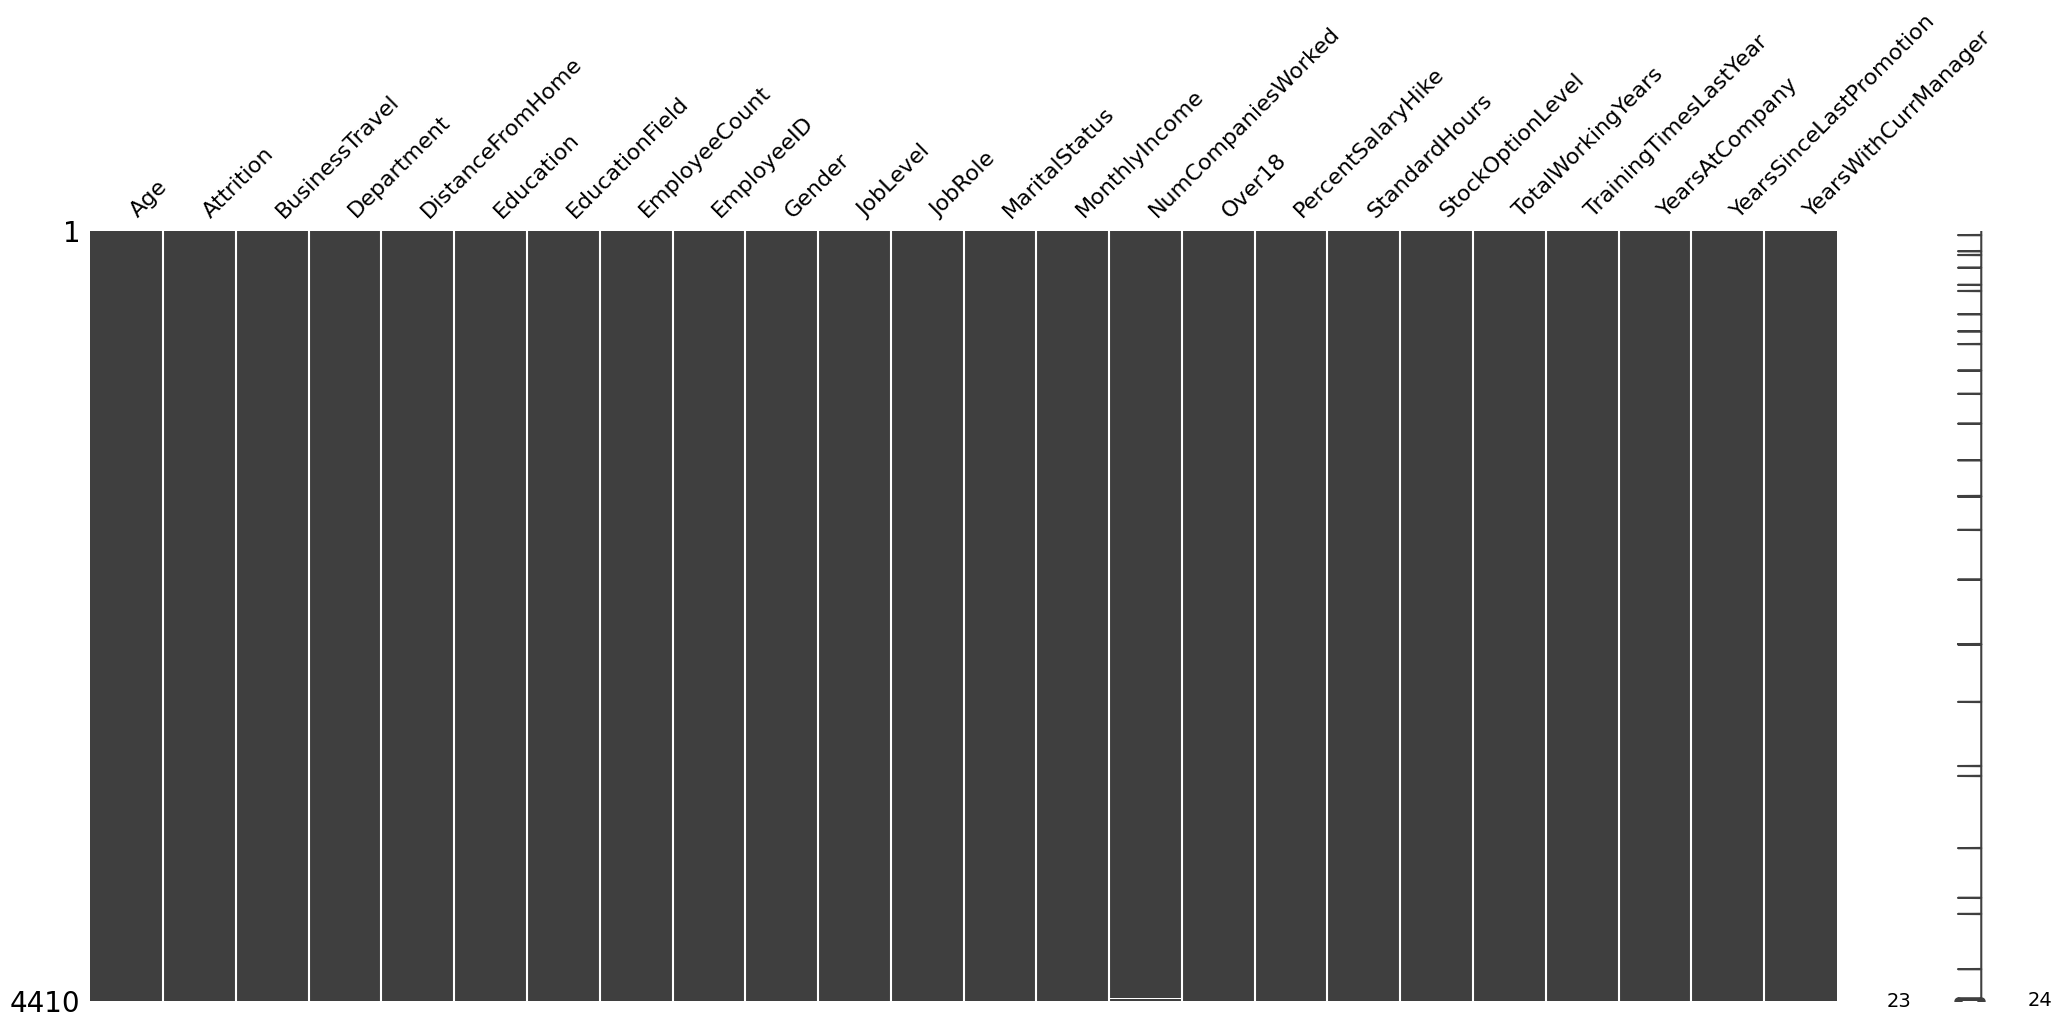

In [34]:
visual_missing_data(general_df,"General Data")

Valeurs manquantes dans Employee Data :
----------------------------


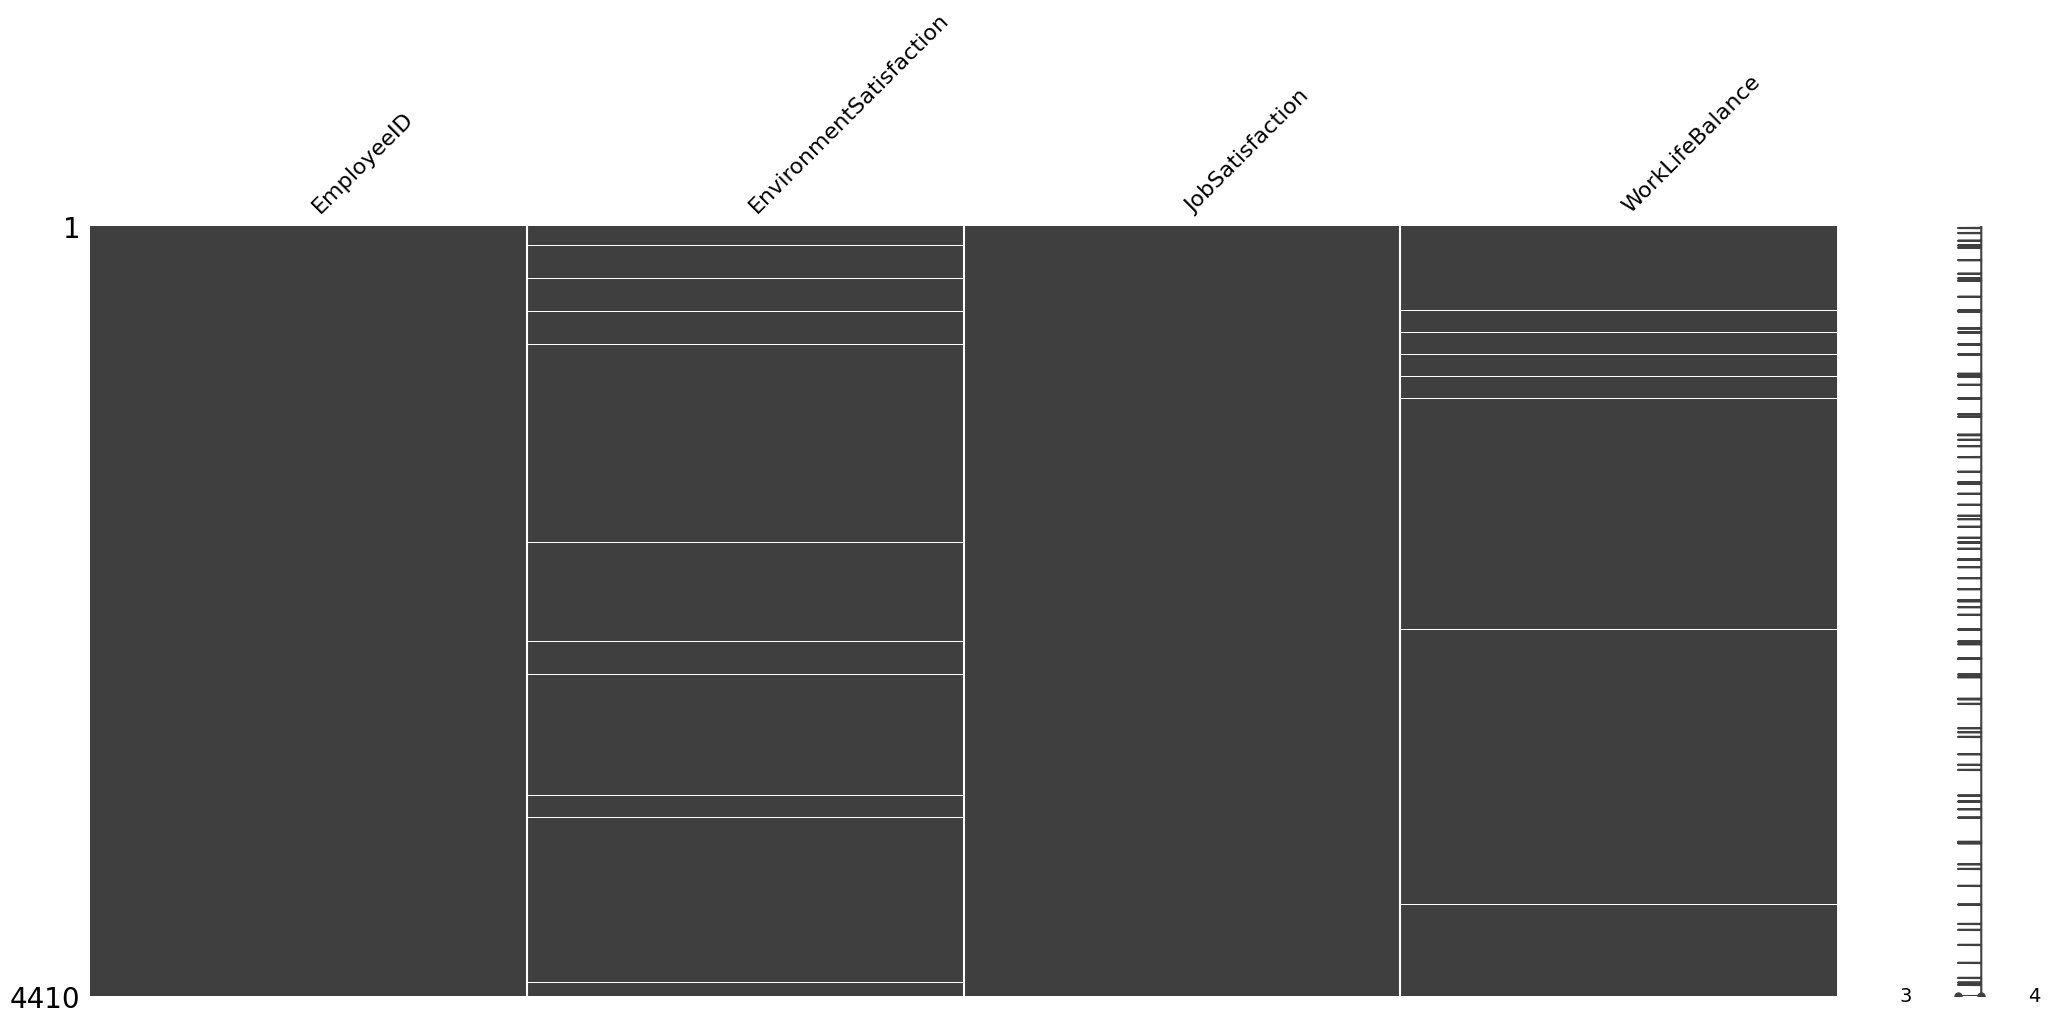

In [35]:
visual_missing_data(employee_df,"Employee Data")

### **4.2 Conclusion sur le manque de données**

**Pour les données du fichier `general_data.csv` :**

* NumCompaniesWorked présente 19 valeurs manquantes.
* TotalWorkingYears présente 9 valeurs manquantes.

**Pour les données du fichier `manager_survey_data.csv` :**

* Aucune valeur manquante.

**Pour les données du fichier `employee_survey_data.csv` :**

* EnvironmentSatisfaction présente 25 valeurs manquantes.
* JobSatisfaction présente 20 valeurs manquantes.
* WorkLifeBalance présente 38 valeurs manquantes.
* EmployeeID est complet, ce qui facilite l’imputation ou la gestion de ces valeurs manquantes.

Les valeurs manquantes identifiées nous informent qu’il faudra faire une étape de nettoyage supplémentaire avant l’analyse exploratoire complète. Les statistiques descriptives devront être calculées après la gestion de ces valeurs manquantes.

### **4.3 Remplacement des données manquantes**

**Pour Variables numériques (ex. NumCompaniesWorked, TotalWorkingYears) :** Remplacer les NA par la médiane

In [36]:
# Imputation des valeurs manquantes dans general_df
# Imputation des valeurs manquantes dans la colonne NumCompaniesWorked
impute_median(general_df, 'NumCompaniesWorked')
# Imputation des valeurs manquantes dans la colonne TotalWorkingYears
impute_median(general_df, 'TotalWorkingYears')

# Imputation des valeurs manquantes dans employee_df
# Imputation des valeurs manquantes dans la colonne EnvironmentSatisfaction
impute_median(employee_df, 'EnvironmentSatisfaction')
# Imputation des valeurs manquantes dans la colonne JobSatisfaction
impute_median(employee_df, 'JobSatisfaction')
# Imputation des valeurs manquantes dans la colonne WorkLifeBalance
impute_median(employee_df, 'WorkLifeBalance')

KeyError: 'NumCompaniesWorked'

### **4.4 Vérification d’imputation**

In [ ]:
# Vérification des valeurs manquantes dans general_df
textual_missing_data(general_df,"General Data")
visual_missing_data(general_df,"General Data")
# Vérification des valeurs manquantes dans employee_df
textual_missing_data(employee_df,"Employee Data")
visual_missing_data(employee_df,"Employee Data")

## **5. Analyse exploratoire des données**

### **5.1 Analyse Descriptive**

In [29]:
display_describe(general_df)
display_describe(manager_df)
display_describe(employee_df)

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
count,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,4410.000000,4391.000000,4410.000000,4410.0,4410.000000,4401.000000,4410.000000,4410.000000,4410.000000,4410.000000
mean,36.923810,9.192517,2.912925,1.0,2205.500000,2.063946,65029.312925,2.694830,15.209524,8.0,0.793878,11.279936,2.799320,7.008163,2.187755,4.123129
std,9.133301,8.105026,1.023933,0.0,1273.201673,1.106689,47068.888559,2.498887,3.659108,0.0,0.851883,7.782222,1.288978,6.125135,3.221699,3.567327
min,18.000000,1.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,2.000000,2.000000,1.0,1103.250000,1.000000,29110.000000,1.000000,12.000000,8.0,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000
50%,36.000000,7.000000,3.000000,1.0,2205.500000,2.000000,49190.000000,2.000000,14.000000,8.0,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000
75%,43.000000,14.000000,4.000000,1.0,3307.750000,3.000000,83800.000000,4.000000,18.000000,8.0,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000
max,60.000000,29.000000,5.000000,1.0,4410.000000,5.000000,199990.000000,9.000000,25.000000,8.0,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000


**Répartition des différentes valeurs**

In [30]:
describe_values_columns(general_df, "MaritalStatus")
describe_values_columns(general_df, "JobRole")
describe_values_columns(general_df, "Attrition")

MaritalStatus
Married     2019
Single      1410
Divorced     981
Name: count, dtype: int64 
--------------------------------------------

JobRole
Sales Executive              978
Research Scientist           876
Laboratory Technician        777
Manufacturing Director       435
Healthcare Representative    393
Manager                      306
Sales Representative         249
Research Director            240
Human Resources              156
Name: count, dtype: int64 
--------------------------------------------

Attrition
No     3699
Yes     711
Name: count, dtype: int64


In [33]:
# Séparer le DataFrame selon Attrition pour savoir si la data est équilibrée
df_yes = general_df[general_df['Attrition']=='Yes']
df_no = general_df[general_df['Attrition']=='No']

print("MonthlyIncome - Attrition=Yes", "\n--------------------------------------------\n")
describe_columns(df_yes, "MonthlyIncome")
print("\nMonthlyIncome - Attrition=No", "\n--------------------------------------------\n")
describe_columns(df_no, "MonthlyIncome")


MonthlyIncome - Attrition=Yes 
--------------------------------------------

count       711.000000
mean      61682.616034
std       44792.067695
min       10090.000000
25%       28440.000000
50%       49080.000000
75%       71040.000000
max      198590.000000
Name: MonthlyIncome, dtype: float64 
--------------------------------------------


MonthlyIncome - Attrition=No 
--------------------------------------------

count      3699.000000
mean      65672.595296
std       47472.814021
min       10510.000000
25%       29360.000000
50%       49300.000000
75%       86060.000000
max      199990.000000
Name: MonthlyIncome, dtype: float64 
--------------------------------------------



##  6. Analyse Univariée

### **6.1 Analyse univariée des variables numériques**

In [ ]:
df = merge_dataframe(general_df, manager_df, "EmployeeID")
df = merge_dataframe(df, employee_df, "EmployeeID")

numeric_cols = ['Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'PercentSalaryHike']
for col in numeric_cols:
    display_graphics_numeral_column(df, col)

**Distribution de l’Age :** La répartition de l’âge est approximativement symétrique, avec un pic autour de la trentaine, suggérant une population d’employés relativement jeune et homogène.

**Distribution de MonthlyIncome :** Le revenu mensuel est fortement asymétrique vers la droite, indiquant que la majorité des employés gagnent moins, tandis qu’une minorité perçoit des revenus très élevés.

**Distribution de TotalWorkingYears :** Le nombre total d’années d’expérience est concentré sur les premières années, montrant une main-d’œuvre globalement jeune ou peu expérimentée.

**Distribution de YearsAtCompany :** Les années passées dans l’entreprise sont majoritairement faibles, indiquant une ancienneté souvent faible et potentiellement un turnover élevé.

**Distribution de PercentSalaryHike :** Les augmentations de salaire percentuelles sont majoritairement regroupées entre 11% et 15%, suggérant une politique d’augmentation relativement uniforme

### **6.2 Analyse univariée des variables objet**

In [ ]:
# Satisfaction (EnvironmentSatisfaction, JobSatisfaction, WorkLifeBalance) sont souvent entre 1 et 4
# Distribution univariée (catégoriel ordinal)
ordinal_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']
for col in ordinal_cols:
    display_graphics_cat_column(df, col)

**Répartition de EnvironmentSatisfaction :** Les niveaux 3 et 4 (élevé/très élevé) sont plus fréquents, indiquant une bonne satisfaction de l’environnement de travail pour la majorité.

**Répartition de JobSatisfaction :** Les niveaux de satisfaction au travail sont élevés (3 et 4) pour la plupart, signifiant un bon ressenti professionnel global.

**Répartition de WorkLifeBalance :** Le niveau 3 (très satisfaisant) domine, illustrant une perception globalement positive de l’équilibre entre vie professionnelle et personnelle.

In [ ]:
# Pour les variables catégorielles (ex: JobRole, MaritalStatus)
cat_cols = ['JobRole', 'MaritalStatus', 'Attrition', 'BusinessTravel']
for col in cat_cols:
    display_graphics_cat_column(df, col)

**Répartition de JobRole :** Certains rôles, comme « Sales Executive » et « Research Scientist », dominent, suggérant une structure d’effectifs où certaines fonctions sont plus représentées.

**Répartition de MaritalStatus :** Les employés mariés sont les plus nombreux, ce qui pourrait influencer certaines préférences (équilibre vie pro/vie perso, stabilité).

**Répartition de l'Attrition :** Le nombre d’employés restants est nettement supérieur aux partants, mais la proportion de départs est suffisante pour justifier une analyse des causes.

**Répartition de BusinessTravel :** La plupart des employés voyagent rarement, laissant penser que la mobilité fréquente n’est pas la norme.

## 7. Analyse Bivariée

### **7.1 Relation entre variables numériques**

In [ ]:
num_vars = ['Age', 'DistanceFromHome' , 'Education' , 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'PercentSalaryHike', 'JobInvolvement', 'PerformanceRating', 'YearsWithCurrManager']
display_heatmap_numeric_values(df,num_vars)

Heatmap des corrélations : L’âge et l’ancienneté totale (TotalWorkingYears) sont fortement corrélés, ce qui est logique, tandis que d’autres corrélations sont plus faibles, suggérant peu de relations linéaires marquées entre les variables numériques.

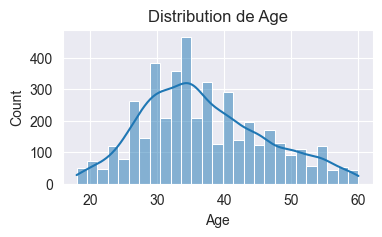

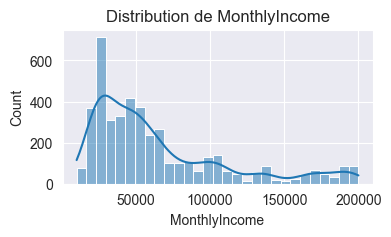

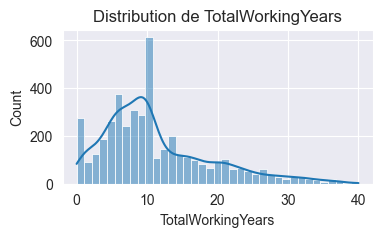

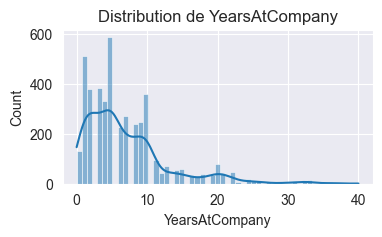

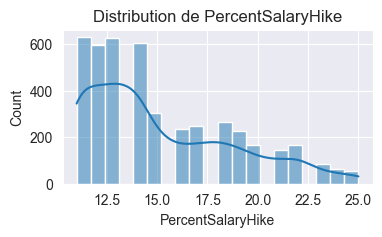

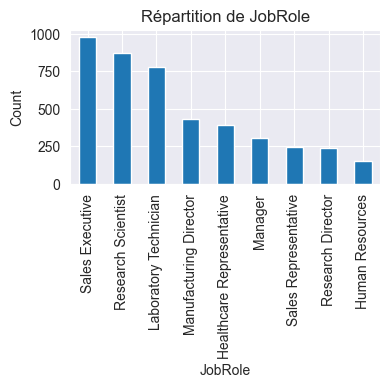

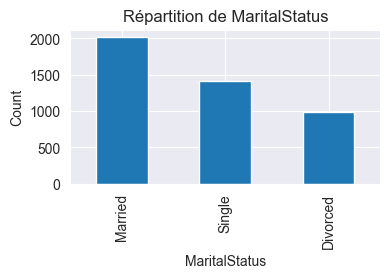

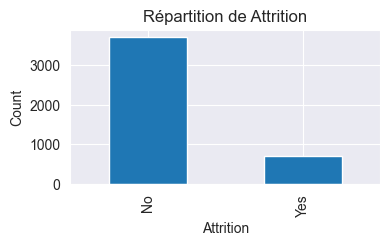

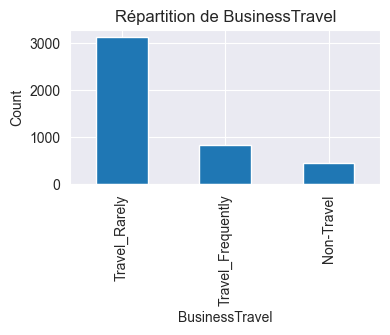

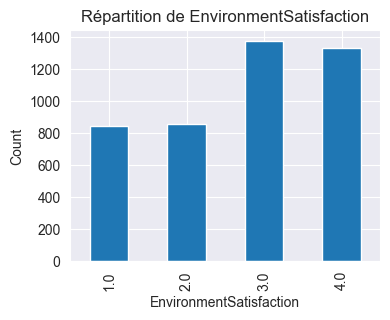

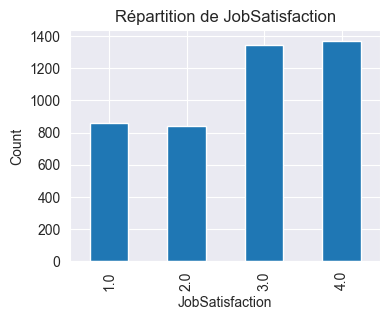

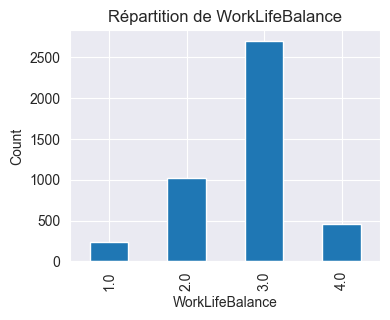

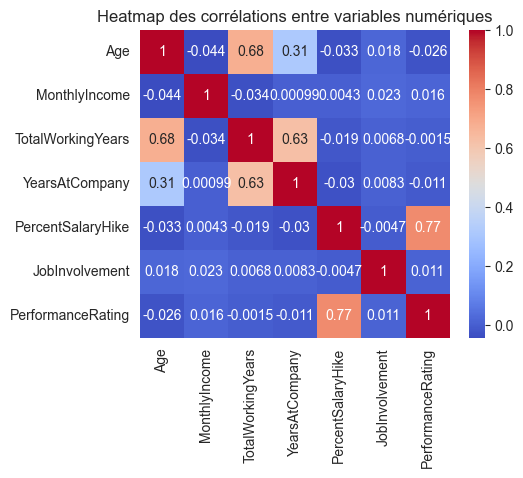

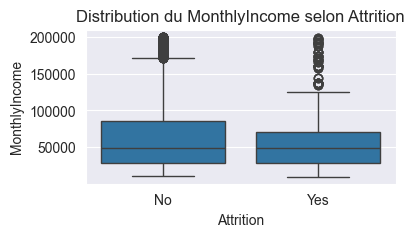

T-test MonthlyIncome vs Attrition:
Statistique = -2.154039144872409 p-value = 0.031466216207610545
BusinessTravel  Non-Travel  Travel_Frequently  Travel_Rarely
Attrition                                                   
No                     414                624           2661
Yes                     36                207            468


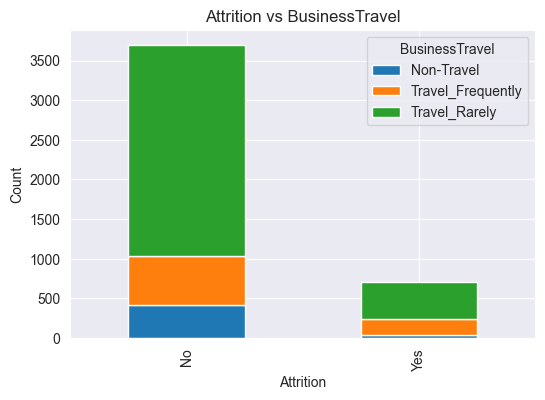

In [40]:
# b) Relation variable numérique vs catégorielle
# Exemple : Impact de l'Attrition sur MonthlyIncome
plt.figure(figsize=(4,2))
sns.boxplot(x='Attrition', y='MonthlyIncome', data=df)
plt.title("Distribution du MonthlyIncome selon Attrition")
plt.show()

# Tester s'il y a une différence significative (test statistique, ex: t-test) entre MonthlyIncome pour Attrition Yes/No
yes_income = df[df['Attrition']=='Yes']['MonthlyIncome']
no_income = df[df['Attrition']=='No']['MonthlyIncome']

from scipy.stats import ttest_ind
stat, pval = ttest_ind(yes_income.dropna(), no_income.dropna(), equal_var=False)
print("T-test MonthlyIncome vs Attrition:")
print("Statistique =", stat, "p-value =", pval)

# Si p-value < 0.05, différence significative, suggérant une relation entre Attrition et MonthlyIncome

# c) Relation entre deux variables catégorielles
# Par exemple, Attrition et BusinessTravel
contingency = pd.crosstab(df['Attrition'], df['BusinessTravel'])
print(contingency)

# Visualisation
contingency.plot(kind='bar', stacked=True, figsize=(6,4))
plt.title("Attrition vs BusinessTravel")
plt.xlabel("Attrition")
plt.ylabel("Count")
plt.show()